In [2]:
import pandas as pd
import h5py
import numpy as np


df_train = pd.read_csv('..//data/processed_metadata_train.csv')
df_test = pd.read_csv('..//data/processed_metadata_test.csv')

In [3]:
def load_keypoints_and_descriptors(descriptors_file):
    data = {}
    with h5py.File(descriptors_file, 'r') as df:
        for key in df.keys():
            #keypoints = np.array(kf[key])
            descriptors = np.array(df[key])
            data[key] = descriptors
    return data

#keypoints_file = "../data/feature_descriptors_train/keypoints.h5"
descriptors_file = "../data/feature_descriptors_train/descriptors.h5"

train_ds = load_keypoints_and_descriptors(descriptors_file)
print(f"Loaded dataset with {len(train_ds)} images.")
    

Loaded dataset with 2928 images.


In [4]:
def stack_all_descriptors(image_descriptors):

    all_descriptors = np.vstack(list(image_descriptors.values()))  # Stack all descriptors
    return all_descriptors

descriptors_train = stack_all_descriptors(train_ds)

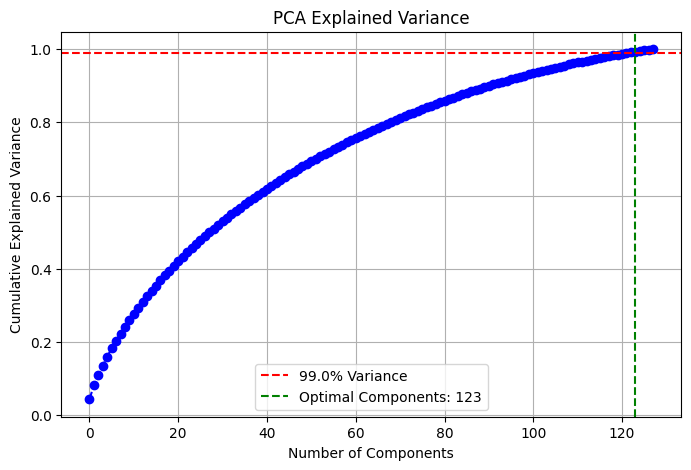

Optimal number of PCA components: 123


In [5]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def determine_optimal_pca_components(descriptors, variance_threshold=0.95, plot=False):

    # Fit PCA to calculate explained variance
    pca = PCA()
    pca.fit(descriptors)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components that meet the variance threshold
    optimal_components = np.searchsorted(cumulative_variance, variance_threshold) + 1

    if plot:
        # Plot cumulative explained variance
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
        plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f"{variance_threshold*100}% Variance")
        plt.axvline(x=optimal_components, color='g', linestyle='--', label=f"Optimal Components: {optimal_components}")
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("PCA Explained Variance")
        plt.legend()
        plt.grid()
        plt.show()

    return optimal_components

# Determine optimal PCA components
optimal_components = determine_optimal_pca_components(
    descriptors_train,
    variance_threshold=0.99,
    plot=True
)
print(f"Optimal number of PCA components: {optimal_components}")


In [6]:
def train_pca(all_descriptors, n_components=123):

    print("Training PCA...")
    pca = PCA(n_components=n_components, whiten=True)
    pca.fit(all_descriptors)
    print("PCA training completed.")
    return pca



In [7]:
from sklearn.mixture import GaussianMixture

def train_gmm(all_reduced_descriptors, n_components=2):

    print("Training GMM...")
    gmm = GaussianMixture(n_components=n_components, covariance_type='diag', random_state=42)
    gmm.fit(all_reduced_descriptors)
    print("GMM training completed.")
    return gmm


#reduced_train_descriptors = pca_model.transform(descriptors_train)
#gmm = train_gmm(reduced_train_descriptors)

In [19]:
def compute_fisher_vectors(reduced_descriptors, gmm):

    means = gmm.means_  # Shape: (K, D)
    covariances = gmm.covariances_  # Shape: (K, D)
    weights = gmm.weights_  # Shape: (K,)

    N, D = reduced_descriptors.shape
    K = len(weights)

    # Compute responsibilities
    responsibilities = gmm.predict_proba(reduced_descriptors)  # Shape: (N, K)

    # Initialize Fisher Vector components
    fisher_mean = np.zeros((K, D), dtype=np.float32)
    fisher_var = np.zeros((K, D), dtype=np.float32)

    # Compute mean and variance gradients
    for k in range(K):
        prob_k = responsibilities[:, k]  # Shape: (N,)
        diff = reduced_descriptors - means[k]  # Shape: (N, D)

        fisher_mean[k] = np.sum(prob_k[:, np.newaxis] * diff / np.sqrt(covariances[k]), axis=0)
        fisher_var[k] = np.sum(prob_k[:, np.newaxis] * (diff ** 2 - covariances[k]) / (2 * covariances[k] ** 1.5), axis=0)

    # Flatten and concatenate mean and variance gradients
    fisher_vector = np.concatenate([fisher_mean.flatten(), fisher_var.flatten()])

    # Apply power normalization
    fisher_vector = np.sign(fisher_vector) * np.sqrt(np.abs(fisher_vector))

    # Apply L2 normalization
    fisher_vector /= np.linalg.norm(fisher_vector)

    return fisher_vector


In [23]:
def compute_fisher_vectors_for_images(image_descriptors, pca, gmm):

    fisher_vectors = {}

    for image_id, descriptors in image_descriptors.items():
        if descriptors.shape[0] == 0:  # Check for empty descriptors
            print(f"Skipping image {image_id}: no descriptors found.")
            continue
        # Apply PCA
        reduced_descriptors = pca.transform(descriptors)

        # Compute Fisher Vector
        fisher_vector = compute_fisher_vectors(reduced_descriptors, gmm)
        fisher_vectors[image_id] = fisher_vector

    return fisher_vectors


In [39]:
pca_model = train_pca(descriptors_train)
reduced_train_descriptors = pca_model.transform(descriptors_train)
gmm = train_gmm(reduced_train_descriptors)
train_fisher_vectors = compute_fisher_vectors_for_images(train_ds, pca_model, gmm)

Training PCA...
PCA training completed.
Training GMM...
GMM training completed.
Skipping image 6f1d0705c91c2145: no descriptors found.


In [26]:
# Save PCA, GMM, and Fisher Vectors
import pickle

with open("pca_model.pkl", "wb") as f:
    pickle.dump(pca_model, f)

with open("gmm_model.pkl", "wb") as f:
    pickle.dump(gmm, f)

with open("fisher_vectors.pkl", "wb") as f:
    pickle.dump(fisher_vectors, f)


In [37]:
from sklearn.metrics.pairwise import cosine_similarity

def classify_test_images(test_fisher_vectors, train_fisher_vectors, train_labels, top_n = 5):

    predictions = {}

    # Stack train Fisher Vectors and labels for efficient comparison
    train_vectors = np.stack(list(train_fisher_vectors.values()))
    train_image_ids = list(train_fisher_vectors.keys())
    train_class_labels = np.array([train_labels[image_id] for image_id in train_image_ids])

    for test_image_id, test_fisher_vector in test_fisher_vectors.items():
        # Normalize Fisher Vectors for cosine similarity
        test_fisher_vector = test_fisher_vector / np.linalg.norm(test_fisher_vector)
        train_vectors_normalized = train_vectors / np.linalg.norm(train_vectors, axis=1, keepdims=True)

        # Compute cosine similarity
        similarities = np.dot(train_vectors_normalized, test_fisher_vector)

        # Sort similarities in descending order
        sorted_indices = np.argsort(similarities)[::-1]
        top_indices = sorted_indices[:top_n]

        # Get top-N class labels and similarities
        top_n_matches = [(similarities[i], train_class_labels[i]) for i in top_indices]

        # Predicted class is the class of the most similar train image
        predicted_class = top_n_matches[0][1]

        # Save the prediction and top-N matches
        predictions[test_image_id] = {
            'predicted_class': predicted_class,
            'top_n': top_n_matches
        }

    return predictions


In [46]:
train_labels = dict(zip(df_train['image_id'], df_train['identity']))
test_labels = dict(zip(df_test['image_id'], df_test['identity']))

In [30]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_predictions(predictions, ground_truth):

    # Extract predicted and true labels
    y_pred = np.array([predictions[image_id] for image_id in ground_truth.keys()])
    y_true = np.array([ground_truth[image_id] for image_id in ground_truth.keys()])

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Print detailed classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    return accuracy


In [ ]:
descriptors_file = "../data/feature_descriptors_test/descriptors.h5"

test_ds = load_keypoints_and_descriptors(descriptors_file)
print(f"Loaded dataset with {len(test_ds)} images.")

Loaded dataset with 723 images.


In [35]:
descriptors_test = stack_all_descriptors(test_ds)

In [38]:
reduced_test_descriptors = pca_model.transform(descriptors_test)
test_fisher_vectors = compute_fisher_vectors_for_images(test_ds, pca_model, gmm)

In [40]:
predictions = classify_test_images(test_fisher_vectors, train_fisher_vectors, train_labels, 10)

In [51]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_predictions(predictions, ground_truth, top_n=5):

    y_true = []
    y_pred = []
    top_n_hits = 0  # Count correct predictions within top-N

    for image_id, result in predictions.items():
        true_class = ground_truth[image_id]  # True class for this test image
        predicted_class = result['predicted_class']  # Predicted class
        top_n_matches = result['top_n']  # Top-N matches

        y_true.append(true_class)
        y_pred.append(predicted_class)

        # Check if true class is in the top-N matches
        if any(class_label == true_class for _, class_label in top_n_matches[:top_n]):
            top_n_hits += 1

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    classification_metrics = classification_report(y_true, y_pred, output_dict=True)

    # Compute top-N accuracy
    top_n_accuracy = top_n_hits / len(y_true)

    # Results summary
    results = {
        'accuracy': accuracy,
        'top_n_accuracy': top_n_accuracy,
        'classification_metrics': classification_metrics
    }

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Top-{top_n} Accuracy: {top_n_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    return results


In [52]:
results = evaluate_predictions(predictions, test_labels)

Accuracy: 0.8202
Top-5 Accuracy: 0.8949
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         5
           9       0.50      1.00      0.67         2
          10       0.75      0.75      0.75         4
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          15       0.67      0.67      0.67         3
          16       1.00      0.75      0.86         4
          18       0.75      0.50      0.60         6
          19       1.00      0.75      0.86         4
          21       1.00      1.00      1.00         3
          22       1.00      0.33      0.50         3
          24      

/home/mm-workstation/re-id/Animal-Re-Identification---MSc-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mm-workstation/re-id/Animal-Re-Identification---MSc-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mm-workstation/re-id/Animal-Re-Identification---MSc-Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

In [ ]:
from sklearn.metrics import confusion_matrix

def find_most_confused_classes(y_true, y_pred, class_names, top_n=5):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_names)

    # Find off-diagonal elements (confusions)
    most_confused = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j:  # Ignore diagonal elements
                most_confused.append((class_names[i], class_names[j], cm[i, j]))

    # Sort by confusion count in descending order
    most_confused = sorted(most_confused, key=lambda x: x[2], reverse=True)

    # Print the top-N most confused class pairs
    print(f"Top-{top_n} Most Confused Classes:")
    for true_class, predicted_class, count in most_confused[:top_n]:
        print(f"True: {true_class}, Predicted: {predicted_class}, Count: {count}")

    return most_confused[:top_n]

In [67]:
# Example data
y_true = [test_labels[image_id] for image_id in predictions.keys()]
y_pred = [predictions[image_id]['predicted_class'] for image_id in predictions.keys()]
class_names = sorted(set(y_true))  # Unique class names

# Find and print the most confused classes
most_confused = find_most_confused_classes(y_true, y_pred, class_names, top_n=10)

Top-10 Most Confused Classes:
True: 156, Predicted: 159, Count: 3
True: 156, Predicted: 153, Count: 2
True: 159, Predicted: 156, Count: 2
True: 160, Predicted: 156, Count: 2
True: 160, Predicted: 162, Count: 2
True: 162, Predicted: 160, Count: 2
True: 270, Predicted: 243, Count: 2
True: 273, Predicted: 249, Count: 2
True: 10, Predicted: 61, Count: 1
True: 15, Predicted: 61, Count: 1


<module 'rembg.sessions' from '/home/mm-workstation/re-id/Animal-Re-Identification---MSc-Project/venv/lib/python3.12/site-packages/rembg/sessions/__init__.py'>